Loading the Data set below and doing some initial data exploration:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')



In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/irenebratsis/Thinkful/master/avocado.csv', encoding='latin1')


In [3]:
for col in df.columns: 
    print(col)

Unnamed: 0
Date
AveragePrice
Total Volume
4046
4225
4770
Total Bags
Small Bags
Large Bags
XLarge Bags
type
year
region


In [4]:
non_numeric_columns = df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['Date', 'type', 'region'], dtype='object')
The number of non-numerical columns is 3


In [5]:
numeric_columns = df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['Unnamed: 0', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'year'],
      dtype='object')
The number of numerical columns is 11


In [6]:
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
region,0,0.0
year,0,0.0
type,0,0.0
XLarge Bags,0,0.0
Large Bags,0,0.0
Small Bags,0,0.0
Total Bags,0,0.0
4770,0,0.0
4225,0,0.0
4046,0,0.0


I don't have any nulls below but I would be filling in nulls and applying windsorization techniques to account for outliers below if I did need to clean the data:

In [7]:
df.isnull().sum()*100/df.count()


Unnamed: 0      0.0
Date            0.0
AveragePrice    0.0
Total Volume    0.0
4046            0.0
4225            0.0
4770            0.0
Total Bags      0.0
Small Bags      0.0
Large Bags      0.0
XLarge Bags     0.0
type            0.0
year            0.0
region          0.0
dtype: float64

Standardizing the columns below for future use so that they don't include random spaces, capital letters and special characters that might get in the way later when we perform multivariant analysis.

In [8]:
df.columns = df.columns.str.replace(' ', '')
df.columns = df.columns.str.strip()

In [9]:
for col in df.columns: 
    print(col)

Unnamed:0
Date
AveragePrice
TotalVolume
4046
4225
4770
TotalBags
SmallBags
LargeBags
XLargeBags
type
year
region


In [10]:
df.columns = map(str.lower, df.columns)

Data exploration to understand correlations and special relationship between the data:

In [11]:
df[df.columns[1:]].corr()['averageprice'][:]


averageprice    1.000000
totalvolume    -0.192752
4046           -0.208317
4225           -0.172928
4770           -0.179446
totalbags      -0.177088
smallbags      -0.174730
largebags      -0.172940
xlargebags     -0.117592
year            0.093197
Name: averageprice, dtype: float64

In [32]:
df.corr()

,unnamed:0,averageprice,totalvolume,4046,4225,4770,totalbags,smallbags,largebags,xlargebags,year
unnamed:0,1.000000,-0.133008,0.014035,0.017628,0.019829,0.041752,-0.002219,0.000347,-0.009196,-0.011546,-0.171667
averageprice,-0.133008,1.000000,-0.192752,-0.208317,-0.172928,-0.179446,-0.177088,-0.174730,-0.172940,-0.117592,0.093197
totalvolume,0.014035,-0.192752,1.000000,0.977863,0.974181,0.872202,0.963047,0.967238,0.880640,0.747157,0.017193
4046,0.017628,-0.208317,0.977863,1.000000,0.926110,0.833389,0.920057,0.925280,0.838645,0.699377,0.003353
4225,0.019829,-0.172928,0.974181,0.926110,1.000000,0.887855,0.905787,0.916031,0.810015,0.688809,-0.009559
4770,0.041752,-0.179446,0.872202,0.833389,0.887855,1.000000,0.792314,0.802733,0.698471,0.679861,-0.036531
totalbags,-0.002219,-0.177088,0.963047,0.920057,0.905787,0.792314,1.000000,0.994335,0.943009,0.804233,0.071552
smallbags,0.000347,-0.174730,0.967238,0.925280,0.916031,0.802733,0.994335,1.000000,0.902589,0.806845,0.063915
largebags,-0.009196,-0.172940,0.880640,0.838645,0.810015,0.698471,0.943009,0.902589,1.000000,0.710858,0.087891
xlargebags,-0.011546,-0.117592,0.747157,0.699377,0.688809,0.679861,0.804233,0.806845,0.710858,1.000000,0.081033


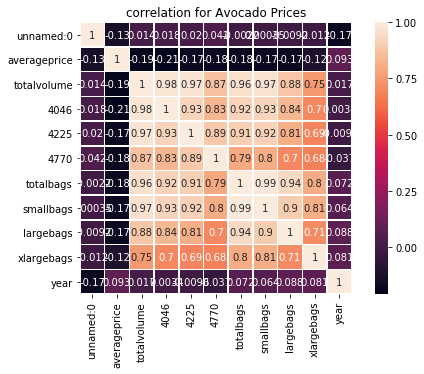

In [12]:
import seaborn as sns

corrmat_df = df.corr()

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
# draw the heatmap using seaborn.
sns.heatmap(corrmat_df, square=True, annot=True, linewidths=.5)
plt.title("correlation for Avocado Prices")

plt.show()

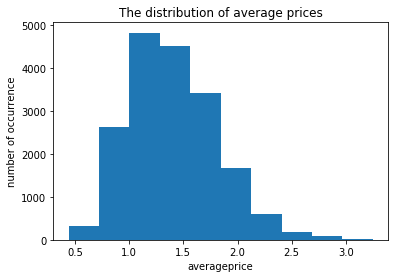

In [13]:
plt.hist(df.averageprice)
plt.title("The distribution of average prices")
plt.xlabel("averageprice")
plt.ylabel("number of occurrence")
plt.show()

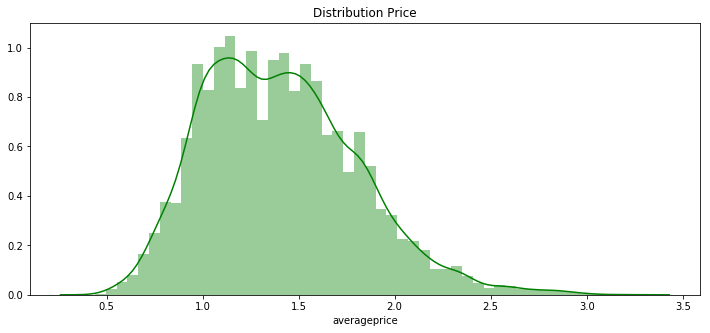

In [14]:
import pylab as pl
pl.figure(figsize=(12,5))
pl.title("Distribution Price")
ax = sns.distplot(df["averageprice"], color = 'g')

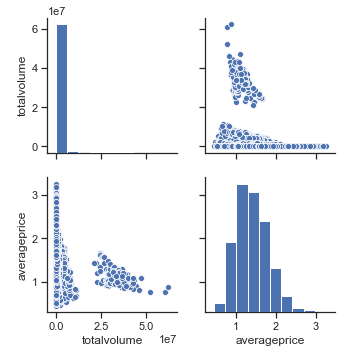

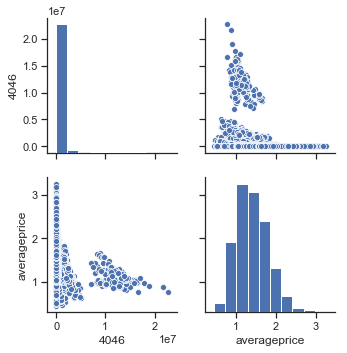

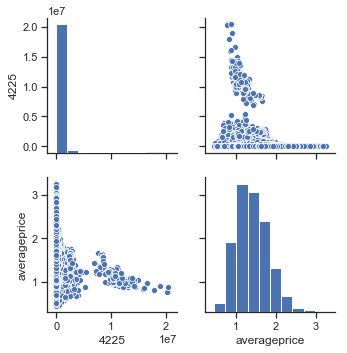

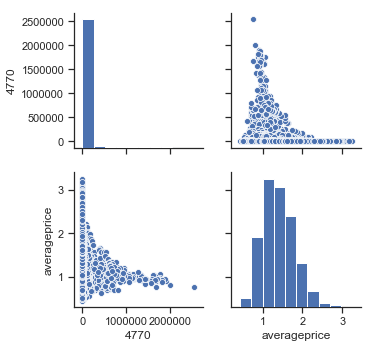

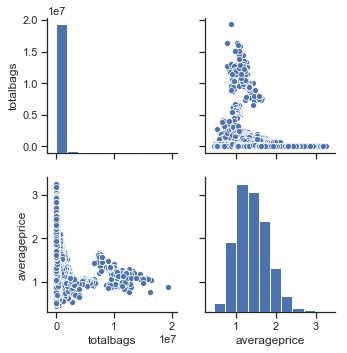

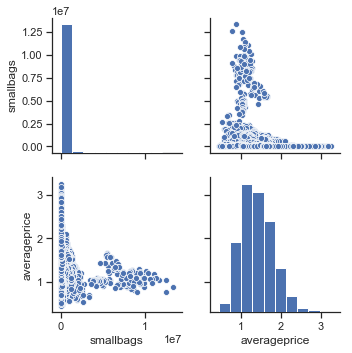

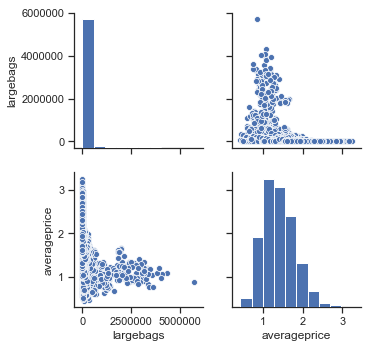

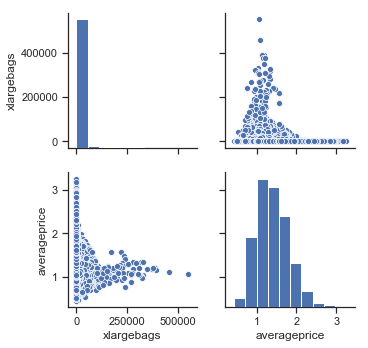

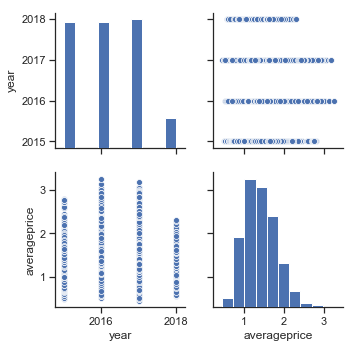

In [15]:

import seaborn as sns
sns.set(style="ticks") 
sns.pairplot(df[['totalvolume', 'averageprice']])
sns.pairplot(df[['4046', 'averageprice']])
sns.pairplot(df[['4225', 'averageprice']])
sns.pairplot(df[['4770', 'averageprice']])
sns.pairplot(df[['totalbags', 'averageprice']])
sns.pairplot(df[['smallbags', 'averageprice']])
sns.pairplot(df[['largebags', 'averageprice']])
sns.pairplot(df[['xlargebags', 'averageprice']])
sns.pairplot(df[['year', 'averageprice']])

In [16]:
df.corr()

,unnamed:0,averageprice,totalvolume,4046,4225,4770,totalbags,smallbags,largebags,xlargebags,year
unnamed:0,1.000000,-0.133008,0.014035,0.017628,0.019829,0.041752,-0.002219,0.000347,-0.009196,-0.011546,-0.171667
averageprice,-0.133008,1.000000,-0.192752,-0.208317,-0.172928,-0.179446,-0.177088,-0.174730,-0.172940,-0.117592,0.093197
totalvolume,0.014035,-0.192752,1.000000,0.977863,0.974181,0.872202,0.963047,0.967238,0.880640,0.747157,0.017193
4046,0.017628,-0.208317,0.977863,1.000000,0.926110,0.833389,0.920057,0.925280,0.838645,0.699377,0.003353
4225,0.019829,-0.172928,0.974181,0.926110,1.000000,0.887855,0.905787,0.916031,0.810015,0.688809,-0.009559
4770,0.041752,-0.179446,0.872202,0.833389,0.887855,1.000000,0.792314,0.802733,0.698471,0.679861,-0.036531
totalbags,-0.002219,-0.177088,0.963047,0.920057,0.905787,0.792314,1.000000,0.994335,0.943009,0.804233,0.071552
smallbags,0.000347,-0.174730,0.967238,0.925280,0.916031,0.802733,0.994335,1.000000,0.902589,0.806845,0.063915
largebags,-0.009196,-0.172940,0.880640,0.838645,0.810015,0.698471,0.943009,0.902589,1.000000,0.710858,0.087891
xlargebags,-0.011546,-0.117592,0.747157,0.699377,0.688809,0.679861,0.804233,0.806845,0.710858,1.000000,0.081033


In [17]:
df[df.columns[1:]].corr()['smallbags'][:]


averageprice   -0.174730
totalvolume     0.967238
4046            0.925280
4225            0.916031
4770            0.802733
totalbags       0.994335
smallbags       1.000000
largebags       0.902589
xlargebags      0.806845
year            0.063915
Name: smallbags, dtype: float64

In [18]:
df.isnull().sum()*100/df.isnull().count()

unnamed:0       0.0
date            0.0
averageprice    0.0
totalvolume     0.0
4046            0.0
4225            0.0
4770            0.0
totalbags       0.0
smallbags       0.0
largebags       0.0
xlargebags      0.0
type            0.0
year            0.0
region          0.0
dtype: float64

'totalvolume', '4046', '4225', '4770', 'totalbags', 'smallbags', 'largebags', 'xlargebags', 'year'

These are the 9 variables that I found most impactful to sale prices based on the .corr list below as well as other data exploration steps done above. For this reason I will be using these variables in my model preparations further in this challenge.

Let's start our model exploration! 

First up OLS with R-squared:	0.928 and TEST R-squared:	0.927

In [19]:

X = df[['totalvolume', '4046', '4225', '4770', 'totalbags', 'smallbags', 'largebags', 'xlargebags', 'year' ]] 
Y = df['averageprice']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(Y_train, X_train).fit()


print(results.summary())



                            OLS Regression Results                            
Dep. Variable:           averageprice   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.100e+04
Date:                Wed, 02 Oct 2019   Prob (F-statistic):               0.00
Time:                        21:16:23   Log-Likelihood:                -7050.6
No. Observations:               14599   AIC:                         1.412e+04
Df Residuals:                   14590   BIC:                         1.419e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
totalvolume     0.0002   6.28e-05      2.426      

In [20]:

X = df[['totalvolume', '4046', '4225', '4770', 'totalbags', 'smallbags', 'largebags', 'xlargebags', 'year' ]] 
Y = df['averageprice']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results_TEST = sm.OLS(Y_test, X_test).fit()


results_TEST.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           averageprice   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     5169.
Date:                Wed, 02 Oct 2019   Prob (F-statistic):               0.00
Time:                        21:16:23   Log-Likelihood:                -1752.5
No. Observations:                3650   AIC:                             3523.
Df Residuals:                    3641   BIC:                             3579.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
totalvolume     0.0003      0.000      1.761      0.078   -3.39e-05       0.001
4046           -0.0003      0.000     -1.761      0.078      -0.001    3.37e-05
4225           -0.0003      0.000     -1.760      0.078      -0.001    3.39e-05
4770           -0.0003      0.000     -1.764      0.078      -0.001    3.33e-05
totalbags      -0.0473      0.101     -0.467      0.640      -0.246       0.151
smallbags       0.0470      0.101      0.464      0.642      -0.151       0.245
largebags       0.0470      0.101      0.464      0.642      -0.151       0.245
xlargebags      0.0470      0.101      0.464      0.642      -0.151       0.245
year            0.0007   3.33e-06    210.518      0.000       0.001       0.001
==============================================================================
Omnibus:                      224.778   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.743
Skew:                           0.632   Prob(JB):                     7.25e-59
Kurtosis:                       3.400   Cond. No.                     1.34e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Next up Ridge Regression with a score of 0.0593 for the training set and a 0.0598 score for the test set 

Review with technical support***

In [29]:
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(fit_intercept = False) 
ridgeregr.fit(X_train, Y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))



R-squared of the model on the training set is: 0.05139662926735733
-----Test set statistics-----
R-squared of the model on the test set is: 0.052159434773465185
Mean absolute error of the prediction is: 0.316161957952777
Mean squared error of the prediction is: 0.15348288994102904
Root mean squared error of the prediction is: 0.39176892416452463
Mean absolute percentage error of the prediction is: 25.209372208337744


Similar results with Lasso with a training set score of 0.05071 and a test set score of 0.05121

In [22]:
from sklearn.linear_model import Lasso

lassoregr = Lasso() 
lassoregr.fit(X_train, Y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


R-squared of the model on the training set is: 0.05071466080446607
-----Test set statistics-----
R-squared of the model on the test set is: 0.05121604880571706
Mean absolute error of the prediction is: 0.316466478507989
Mean squared error of the prediction is: 0.15363565150238426
Root mean squared error of the prediction is: 0.39196383953419
Mean absolute percentage error of the prediction is: 25.233773450495


With ElasticNet we finish off with an identical training set score of 0.05071 and a test set score of 0.05121

In [23]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet() 
elasticregr.fit(X_train, Y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


R-squared of the model on the training set is: 0.05071472192973714
-----Test set statistics-----
R-squared of the model on the test set is: 0.05121940063771391
Mean absolute error of the prediction is: 0.316464879811314
Mean squared error of the prediction is: 0.1536351087435276
Root mean squared error of the prediction is: 0.39196314717525116
Mean absolute percentage error of the prediction is: 25.233586569363865


We do see a modest improvement with Linear Regression training set score of 0.05935 and a test set score of 0.059818

In [24]:
lrm = LinearRegression()

lrm.fit(X_train, Y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))

R-squared of the model in training set is: 0.05935381164845188
-----Test set statistics-----
R-squared of the model in test set is: 0.05981883844169622
Mean absolute error of the prediction is: 0.3142602562283632
Mean squared error of the prediction is: 0.1522426102427825
Root mean squared error of the prediction is: 0.3901827908080807
Mean absolute percentage error of the prediction is: 25.03369151551186


Let's see what happens if we turn this into a Decision Tree:

In [25]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import pydotplus
import graphviz
from sklearn import tree

# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# Initialize and train our tree.
regressor = DecisionTreeRegressor()


regressor.fit(X_train, Y_train)

print("R-squared of the model in training set is: {}".format(regressor.score(X_train, Y_train)))


R-squared of the model in training set is: 1.0


And a Random Forest:

In [33]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import ensemble

randomforest = RandomForestRegressor()
randomforest.fit(X_train, Y_train)
randomforest.score(X_test, Y_test)





0.7871756314948155

And finally, KNN:

In [34]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, Y_train)
knn.score(X_test, Y_test)



0.6704258396120537

In [35]:
# Run the same model, this time with weights.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_w.fit(X_train, Y_train)
knn_w.score(X_test, Y_test)



0.6869363228404677

In [36]:
# Adjusting weights to see if there is an improvement in the performance
knn_w2 = neighbors.KNeighborsRegressor(n_neighbors=2, weights='distance')
knn_w.fit(X_train, Y_train)
knn_w.score(X_test, Y_test)


0.6869363228404677

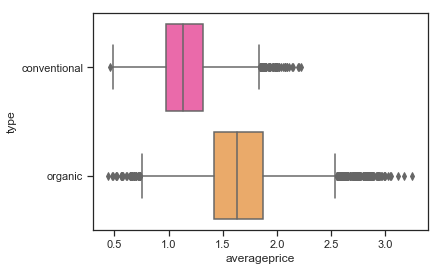

In [37]:
sns.boxplot(y="type", x="averageprice", data=df, palette = 'spring')


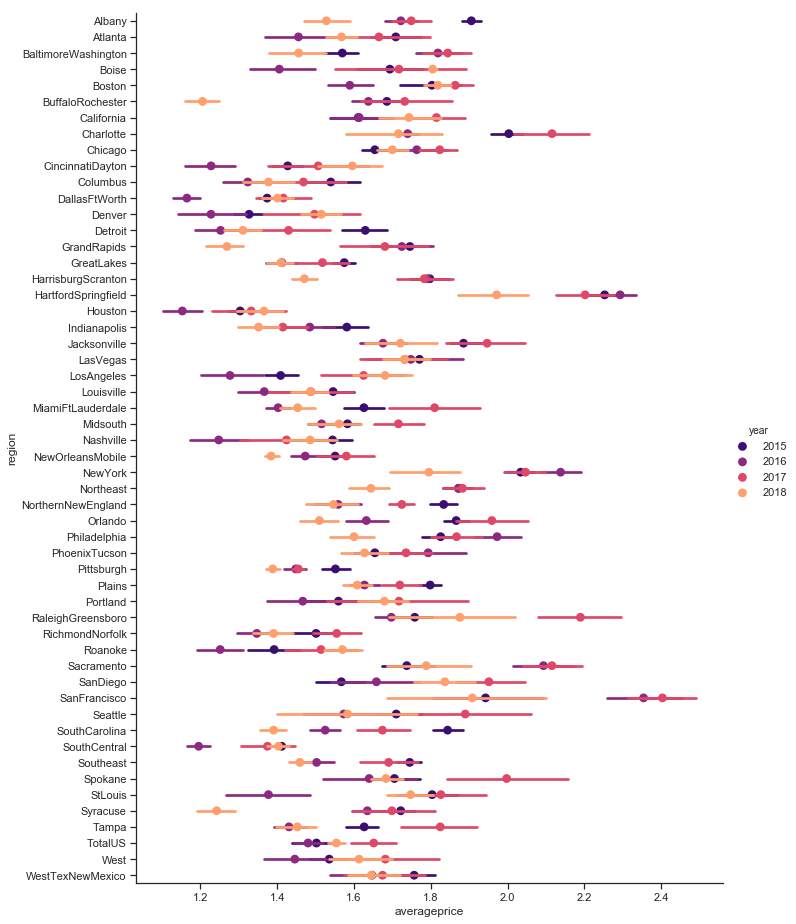

In [38]:
mask = df['type']=='organic'
g = sns.factorplot('averageprice','region',data=df[mask],
                   hue='year',
                   size=13,
                   aspect=0.8,
                   palette='magma',
                   join=False,
              )

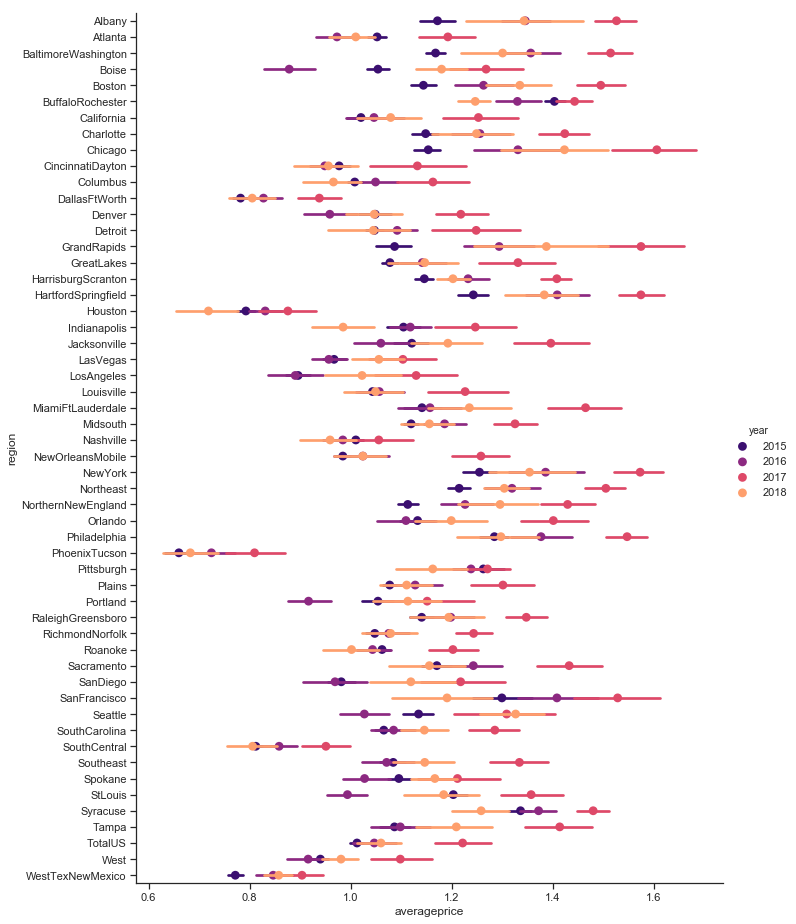

In [39]:
mask = df['type']=='conventional'
g = sns.factorplot('averageprice','region',data=df[mask],
                   hue='year',
                   size=13,
                   aspect=0.8,
                   palette='magma',
                   join=False,
              )

In [41]:
df.head()

,unnamed:0,date,averageprice,totalvolume,4046,4225,4770,totalbags,smallbags,largebags,xlargebags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
